In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import uncertainty_toolbox as uct

In [4]:
from pnn_model import pnn

### Make synthetic dataset

In [5]:
# x = torch.from_numpy(np.sort(np.random.random(20))).float().reshape(-1, 1)
# x = torch.linspace(-10, 10, 200).reshape(-1,1)
x = torch.from_numpy(np.sort(np.random.uniform(low=-10, high=10, size=(300, 1)), axis=0)).float()

In [6]:
fn = lambda x: np.sin(x/2) + x*np.cos(0.8 * x)

In [7]:
def add_noise_fn(in_x):
    noise_list = []
    for x in in_x:
        if -10 <= x < -5:
            eps = np.random.normal(loc=0.0, scale=1)            
        elif -5 <= x < 0:
            eps = np.random.normal(loc=0.0, scale=0.001)
        elif 0<= x < 5:
            eps = np.random.normal(loc=0.0, scale=1.5)
        elif 5 <= x < 10:
            eps = np.random.normal(loc=0.0, scale=0.5)
        noise_list.append(eps)
    
    return torch.tensor(noise_list).reshape(-1,1)

In [8]:
y_mean = fn(x)
y_noise = add_noise_fn(x)
y = y_mean + y_noise

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

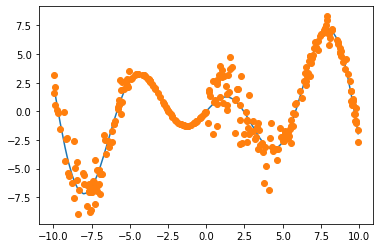

In [9]:
plt.plot(x, y_mean)
plt.plot(x, y, 'o')

<IPython.core.display.Javascript object>

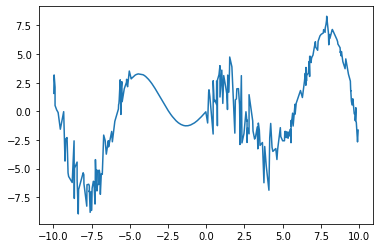

In [10]:
plt.plot(x, y)

In [30]:
model = pnn()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [31]:
x.shape, y.shape

(torch.Size([300, 1]), torch.Size([300, 1]))

In [34]:
data_loader = DataLoader(
    dataset=TensorDataset(x, y),
    shuffle=True, 
    batch_size=x.shape[0])
    
#     dataset=train_set, batch_size=args.batch,
#                                  shuffle=True,
#                                  num_workers=0, #args.num_cpu - 2,
#                                  pin_memory=args.pin_memory)

In [35]:
for epoch in range(500):
    for (batch_x, batch_y) in data_loader:      
        loss = model.loss(batch_x, batch_y)
        opt.zero_grad()
        loss.backward()
        opt.step()

In [36]:
pred_mean, pred_var = model.forward(x)
pred_mean = pred_mean.detach().numpy().flatten()
pred_std = np.sqrt(pred_var.detach().numpy().flatten())

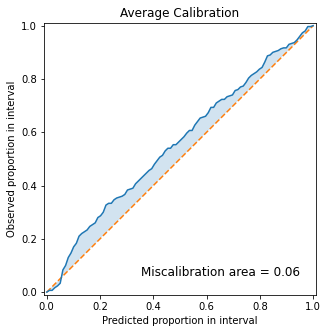

In [37]:
uct.viz.plot_calibration(pred_mean, pred_std, y.numpy().flatten())

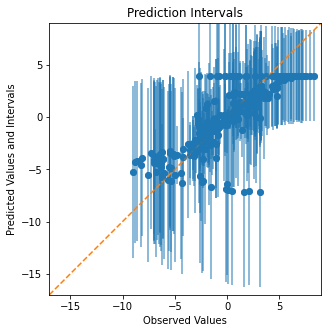

In [38]:
uct.viz.plot_intervals(pred_mean, pred_std, y.numpy().flatten())

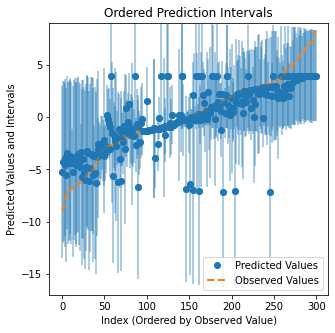

In [40]:
uct.viz.plot_intervals_ordered(pred_mean, pred_std, y.numpy().flatten())

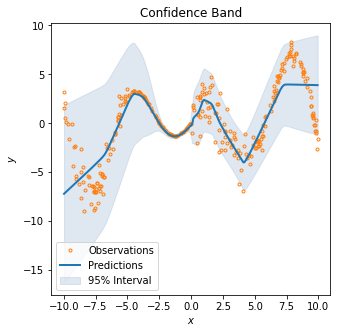

In [42]:
uct.viz.plot_xy(pred_mean, pred_std, y.numpy().flatten(), x.numpy().flatten())

Lims is None. Setting lims now:
min_max_true: (-8.951318, 8.30599)
min_max_pred: (-7.1964893, 3.9653609)
lims: (-8.951318, 8.30599)
lims_ext: (-10.677048683166504, 10.031721115112305)


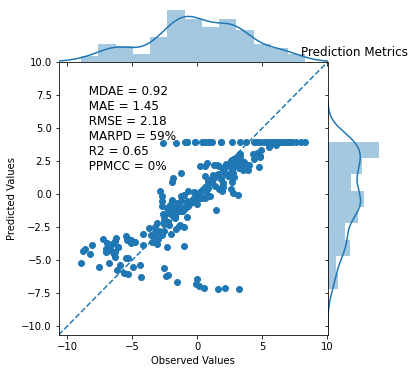

In [43]:
uct.viz.plot_parity(pred_mean, y.numpy().flatten())

In [ ]:
uct.viz.plot_calibration(pred_mean, pred_std, y.numpy())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

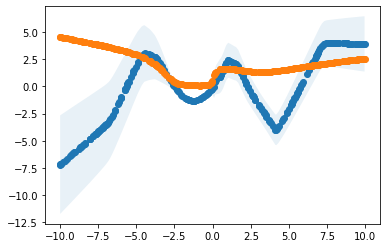

In [44]:
plt.plot(x.flatten(), pred_mean, 'o')
plt.plot(x.flatten(), pred_std, 'o')
plt.fill_between(x.flatten(), pred_mean - pred_std, pred_mean + pred_std, alpha=0.1)

In [144]:
pred_mean.shape, pred_std.shape

((300,), (300,))

In [145]:
y.shape

torch.Size([300, 1])

In [146]:
get_all_metrics(pred_mean, pred_std, y.numpy().flatten())

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 10%|█         | 1/10 [00:00<00:00,  9.56it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 10%|█         | 1/10 [00:00<00:01,  8.86it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  8.30it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           77.505
  RMSE          129.002
  MDAE          3.415
  MARPD         128.938
  R2            -1311.460
  Correlation   -0.375
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.262
  Mean-absolute Calibration Error       0.227
  Miscalibration Area                   0.229
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.267
     Group Size: 0.56 -- Calibration Error: 0.238
     Group Size: 1.00 -- Calibration Error: 0.227
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.314
     Group Size: 0.56 -- Calibration Error: 0.273
     Group Size: 1.00 -- Calibration Error: 0.262
======

{'accuracy': {'mae': 77.50504,
  'rmse': 129.00204,
  'mdae': 3.4154277,
  'marpd': 128.937566280365,
  'r2': -1311.4596131682608,
  'corr': -0.37549588096485176},
 'avg_calibration': {'rms_cal': 0.2616604515764503,
  'ma_cal': 0.22716666666666666,
  'miscal_area': 0.22946127946127945},
 'adv_group_calibration': {'ma_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
   'adv_group_cali_mean': array([0.37710606, 0.26741414, 0.26151274, 0.24427061, 0.24330402,
          0.23795808, 0.237265  , 0.23512446, 0.23243446, 0.22716667]),
   'adv_group_cali_stderr': array([0.05506708, 0.01622366, 0.00547566, 0.00768548, 0.00704367,
          0.00424211, 0.00465344, 0.00308265, 0.00195515, 0.        ])},
  'rms_adv_group_cal': {'group_sizes': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
          0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),

In [148]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern

In [150]:
in_kernel = RBF(3.0, 'fixed')
# in_kernel = Matern(0.5, 'fixed')
print(in_kernel)
gpr = GaussianProcessRegressor(kernel=in_kernel, random_state=0)
gpr.get_params()

RBF(length_scale=3)


{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__length_scale': 3.0,
 'kernel__length_scale_bounds': 'fixed',
 'kernel': RBF(length_scale=3),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

In [151]:
x.shape, y.shape

(torch.Size([300, 1]), torch.Size([300, 1]))

In [152]:
fitted_gpr = gpr.fit(x.numpy(), y.numpy())
fitted_gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__length_scale': 3.0,
 'kernel__length_scale_bounds': 'fixed',
 'kernel': RBF(length_scale=3),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

In [153]:
fitted_gpr.kernel

RBF(length_scale=3)

In [154]:
pred_mean, pred_std = gpr.predict(x.numpy(), return_std=True)

/home/master/anaconda3/envs/py36/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [155]:
pred_mean, pred_std = fitted_gpr.predict(x.numpy(), return_std=True)

/home/master/anaconda3/envs/py36/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [156]:
pred_mean.shape, pred_std.shape

((300, 1), (300,))

In [157]:
pred_std.mean()

0.0028052821845701045

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

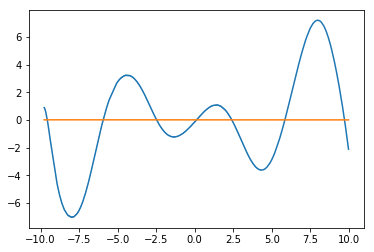

In [158]:
plt.plot(x.numpy().flatten(), pred_mean.flatten())
plt.plot(x.numpy().flatten(), pred_std.flatten())
plt.fill_between(x.numpy().flatten(), pred_mean.flatten() - 10*pred_std,
                pred_mean.flatten() + 10*pred_std,)

In [159]:
pred_std

array([0.00395974, 0.00422874, 0.00345062, 0.00435682, 0.00442815,
       0.00468865, 0.00425161, 0.00471823, 0.00568016, 0.00521948,
       0.00476102, 0.0045789 , 0.00451213, 0.00509061, 0.00520373,
       0.00539676, 0.00526368, 0.00464763, 0.00492869, 0.0049983 ,
       0.00549341, 0.00593008, 0.00506694, 0.00536861, 0.00447571,
       0.00545376, 0.00590751, 0.00483459, 0.00546126, 0.00565485,
       0.00524385, 0.0049507 , 0.00495674, 0.00485951, 0.00513967,
       0.00461247, 0.00523453, 0.00571374, 0.00494944, 0.0046962 ,
       0.00558104, 0.00530718, 0.00498382, 0.00458302, 0.00423648,
       0.00456512, 0.00443187, 0.00431578, 0.00459758, 0.00482995,
       0.00330032, 0.0053863 , 0.00523814, 0.00329007, 0.00522919,
       0.00475342, 0.00426907, 0.0053774 , 0.00430977, 0.00393809,
       0.00504305, 0.00411548, 0.00493574, 0.00442973, 0.00292047,
       0.0037779 , 0.00251257, 0.00509845, 0.00435061, 0.00412567,
       0.00382929, 0.00448422, 0.0026737 , 0.00304766, 0.00340